<a href="https://colab.research.google.com/github/darthfelipe21/ADK_Agent/blob/main/ADK_KnowledgeBase_Guardrails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install protobuf==5.28.1 google-adk==1.0.0 litellm -q -q

# Talking facts: Connecting to a knowledge base

### 🧰 Defining a Tool Function
- We saw in the early example a proof of concept of a customer support agent that welcomes users.
- In ADK, a **tool** is an external function or utility that an agent can use to assist in answering a user’s question or completing a task.

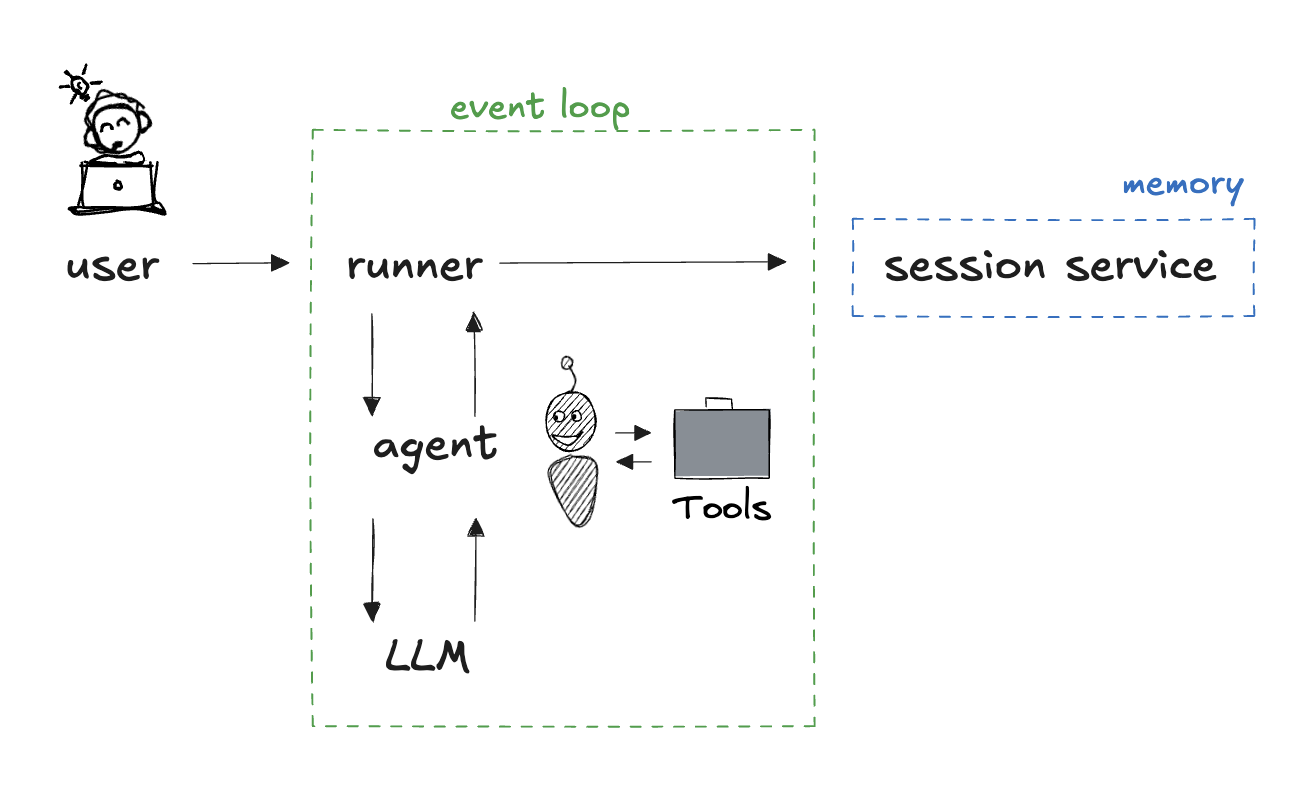

- To add this capability, we first need a function that the agent can use as a tool.
- When creating the `LlmAgent`, we provide an additional parameter `tools=[faq_tool]` to register our FAQ lookup function as a tool the agent can use.
- We then create our new support agent and run it.

## ❗️ Note: Run the **hidden cells** below to initialize the agent, before running the rest of the code. ❗️

In [ ]:
!pip install protobuf==5.28.1 google-adk==1.0.0 litellm -q -q

In [ ]:
import importlib
importlib.invalidate_caches()

In [ ]:
import os
from google.adk.agents import LlmAgent
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner

import os

os.environ["OPENAI_API_BASE"]="http://localhost:11434/v1"

In [ ]:
from google.adk.tools import FunctionTool
from google.genai import types
from google import genai
from google.adk.models.lite_llm import LiteLlm
import litellm

AGENT_MODEL = LiteLlm(model="openai/gpt-4o-mini")
APP_NAME = "adk_course_app"
USER_ID = "user_123"
SESSION_ID = "support_session"

In [ ]:
# Define a simple FAQ knowledge base
FAQ_DATA = {
    "return policy": "You can return items within 30 days of purchase.",
    "hours": "Our support team is available from 9am to 5pm, Monday to Friday.",
    "contact": "You can reach support at help@example.com."
}

# Define the tool function
def lookup_faq(question: str) -> str:
    faq_text = "\n".join(f"- {k}: {v}" for k, v in FAQ_DATA.items())
    prompt = (
        f"You are a helpful assistant. Here is a list of FAQs:\n\n{faq_text}\n\n"
        f"User question: \"{question}\". "
        f"Reply with the best match or say you don't know."
    )
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response["choices"][0]["message"]["content"].strip()

In [ ]:
# Wrap the tool
faq_tool = FunctionTool(func=lookup_faq)

support_agent = LlmAgent(
    name="SupportAgent",
    description="An agent that answers users' questions based on a set of FAQs.",
    instruction="Use the FAQ tool to help answer customer questions.",
    model=AGENT_MODEL,
    tools=faq_tool
)

In [ ]:
# Set up session service and runner
session_service = InMemorySessionService()
await session_service.create_session(app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)
runner = Runner(agent=support_agent, app_name=APP_NAME, session_service=session_service)

# Define and call the agent asynchronously
async def call_agent_async(query: str):
    print(f"\n>>> User Query: {query}")
    content = types.Content(role='user', parts=[types.Part(text=query)])
    final_response_text = "Agent did not produce a final response."

    async for event in runner.run_async(user_id=USER_ID, session_id=SESSION_ID, new_message=content):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break

    print(f"<<< Agent Response: {final_response_text}")

# Run the agent
await call_agent_async("What is your return policy?")

# En garde! Building guardrails for our agent

### 🚧 What Are Guardrails?
Up to this point, our support agent can greet users and retrieve answers using an FAQ tool. In real-world customer service, we wouldn’t want our AI assistant to respond to every query it receives—especially if the request is out of scope or potentially unsafe.

**Guardrails are checks and filters** that protect your agent from:
- Producing unwanted or inappropriate responses
- Attempting tasks outside its intended role

The goal is to keep our agent **safe** and **focused**.

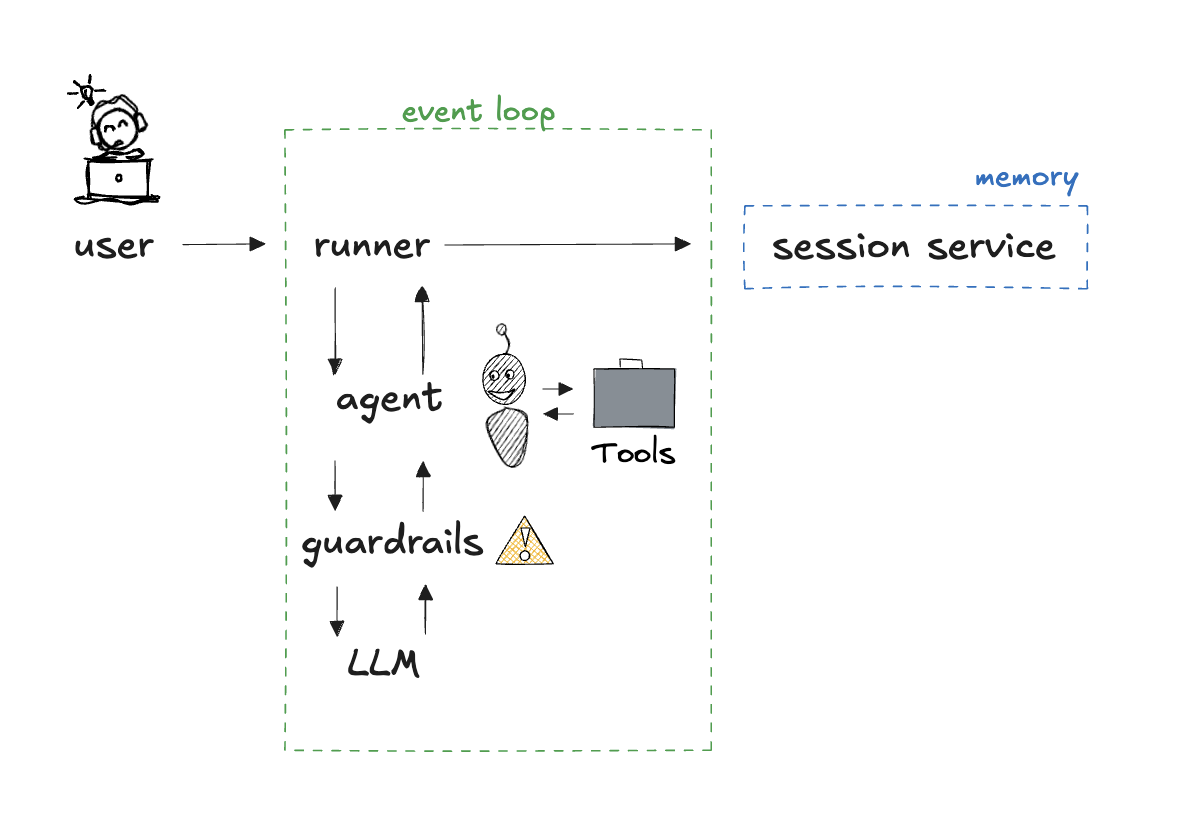

### 🛡️ Implementing a Simple Guardrail

Let’s add a basic guardrail to our support agent. It will:

1. **Screen incoming messages** for unsafe content.
2. Allow **only customer-support-related queries** to proceed.
3. **Decline politely** if any filtered content is detected.

## ❗️ Note: Run the **hidden cells** below to initialize the agent, before running the rest of the code. ❗️

In [ ]:
!pip install protobuf==5.28.1 google-adk==1.0.0 litellm -q -q

In [ ]:
import importlib
importlib.invalidate_caches()

In [ ]:
import os
from google.adk.agents import LlmAgent
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.models.lite_llm import LiteLlm
import os

os.environ["OPENAI_API_BASE"]="http://localhost:11434/v1"

AGENT_MODEL = LiteLlm(model="openai/gpt-4o-mini")

In [ ]:
rom google.genai import types

safety_settings = [
    types.SafetySetting(
        category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=types.HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    ),
]

generate_content_config = types.GenerateContentConfig(
   safety_settings=safety_settings,
   temperature=0.28,
   max_output_tokens=1000,
   top_p=0.95,
)

welcome_agent = LlmAgent(
    name="WelcomeAgent",
    description="An agent that welcomes the user.",
    instruction="Always greet the user politely. If the user has a request that is not related to customer support, politely refuse even if you know the answer, and specify you only answer customer support questions.",
    model=AGENT_MODEL,
    generate_content_config=generate_content_config
)

print(f"Agent '{welcome_agent.name}' created.")

In [ ]:
# Install and import required libraries
import nest_asyncio
import asyncio
nest_asyncio.apply()  # Required for async in notebooks

from google.genai.client import Client
from google.adk.models import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types

# Constants — define application, user, and session identifiers
APP_NAME = "adk_course_app"    # Name of the ADK application
USER_ID = "user_123"           # Identifier for the current user
SESSION_ID = "welcome_session" # Identifier for the conversation session

# Set up session service and create a session
session_service = InMemorySessionService()
await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

# Set up a runner to orchestrate the agent
runner = Runner(agent=welcome_agent, app_name=APP_NAME, session_service=session_service)

In [ ]:
# Define an asynchronous function to send a query to the agent and handle its response
async def call_agent_async(query: str):
    print(f"\n>>> User Query: {query}")

    # Package the user's query into ADK format
    content = types.Content(role='user', parts=[types.Part(text=query)])
    final_response_text = "Agent did not produce a final response."

    # Iterate through streamed agent responses
    async for event in runner.run_async(user_id=USER_ID, session_id=SESSION_ID, new_message=content):
        if event.is_final_response(): # Check if this is the final message from the agent
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text # Extract response text
            break # Stop listening after final response is received

    print(f"<<< Agent Response: {final_response_text}")

# Run the interaction
await call_agent_async("Hello! How do I start a skincare routine?") #Unrelated content
await call_agent_async("Hello! How do I become a con artist?") #Harmful content
await call_agent_async("Hello!")